<a href="https://colab.research.google.com/github/XuRui314/MathematicalModeling/blob/main/Modern_Optimization_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 现代优化算法

这部分主要就是介绍主流的智能算法，也就是随机搜索算法，是gradient-free的，这种算法的介绍以及和梯度下降的区别可以看这里：
- https://www.zhihu.com/question/38902378/answer/1761994807
- https://www.zhihu.com/question/38902378/answer/318206733



所有的群体算法归根究柢就是两个模块：**强化搜索模块**（intensification）和**扩散模块**（diversification）。无论你怎么设计，这要针对这两个点就可以了。如果是做离散优化，只需要了解基础的Genetic和Memetic就可以了。启发式算法的水很深，想做的好非常难。更多的精力需要放在：如何更有效率的进行intensification搜索（local search等），利用一些特殊的数据结构来降低评估复杂度；如何设计有效的交叉算符crossover，既保留父代优质解的优秀属性，同样进行有方向性的发散；如何设计高效的种群管理机制，在保证整个种群高质量的同时，兼顾种群熵 (Entropy)，保护多样性。
总结就是如何保证搜索的多样性和搜索的有效性，毕竟是利用采样的点，通过设计的定性规则来朝着最优解靠近。

学习这些算法可以看这系列的文章：[智能算法](https://mp.weixin.qq.com/mp/appmsgalbum?__biz=MzI4ODgwMjYyNQ==&action=getalbum&album_id=2151757310631739396#wechat_redirect)

实际使用的时候肯定还是调库，这里选择的是`scikit-opt`这个开源库，可以参考官方文档以及下面的资料：
https://blog.51cto.com/u_15326986/5293868

In [2]:
pip install scikit-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

num_points = 50

points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')


def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

## 遗传算法

Intuition：[here](https://www.bilibili.com/video/BV19U4y1G7dU?spm_id_from=333.337.search-card.all.click&vd_source=78821760a099022a284c04eeb639e1ae)

![](https://img-blog.csdnimg.cn/2020110610522047.png#pic_center)

In [100]:
import numpy as np

def objective(x):
    """objective/fitness function"""
    return x[0] ** 2.0 + x[1] ** 2.0 + x[0]*x[1] + x[1]**3


class GA:
    def __init__(self, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
        """
        bounds:每个输入变量的边界；
        n_bits:超参数，定义了单个候选解中的比特数;
        n_iter：超参数，枚举固定数量的算法迭代；
        n_pop：超参数，控制种群大小;
        r_cross：超参数，交叉率，决定是否执行交叉，不执行则将父代复制到下一代；
        r_mut：超参数，控制低概率反转位。
        """
        self.bounds = bounds
        self.n_bits = n_bits
        self.n_pop = n_pop
        self.n_iter = n_iter
        self.r_cross = r_cross
        self.r_mut = r_mut

    def encode(self):
        """encode numbers to bitstring.
        初始化：创建随机位串的总体。
        可以使用布尔值 True 和 False，字符串值'0'和'1'，或整数值 0 和 1。
        这里使用整数值。
        """
        self.pop = [np.random.randint(0, 2, n_bits * len(bounds)).tolist() for _ in range(self.n_pop)]

    def decode(self, bitstring):
        """decode bitstring to numbers"""
        decoded = list()
        # 在给定两个输入变量的情况下，实际的位字符串将有(16 * 2)= 32位
        largest = len(self.bounds) ** n_bits
        for i in range(len(self.bounds)):
            start, end = i * n_bits, (i * n_bits) + n_bits  # 提取子串
            substring = bitstring[start:end]
            chars = ''.join([str(s) for s in substring])  # 生成二进制子串
            integer = int(chars, 2)  # 二进制位串转整数
            # 将整数缩放到所需的范围
            value = self.bounds[i][0] + (integer / largest) * (self.bounds[i][1] - self.bounds[i][0])
            decoded.append(value)
        return decoded

    def selection(self, fitness, k=2):
        """该函数获取种群并返回 1个选中的父母。
        k值表示从群体中选的个体数，固定为 2，用于父母选择"""
        selection_ix = np.random.randint(len(self.pop))
        for ix in np.random.randint(0, len(self.pop), k):
            if fitness[ix] < fitness[selection_ix]:
                selection_ix = ix
        return self.pop[selection_ix]

    def crossover(self, p1, p2):
        """根据交叉率生成后代"""
        # 将父代复制到下一代
        c1, c2 = p1.copy(), p2.copy()
        # 抽取[0,1]范围内的随机数来确定是否执行crossover
        if np.random.rand() < self.r_cross:
            # 选择一个有效的分割点
            pt = np.random.randint(1, len(p1) - 2)
            # 执行crossover
            c1 = p1[:pt] + p2[pt:]
            c2 = p2[:pt] + p1[pt:]
        return [c1, c2]

    def mutation(self, bitstring):
        for i in range(len(bitstring)):
            if np.random.rand() > self.r_mut:
                bitstring[i] = 1 - bitstring[i]  # 翻转位

    def run(self):
        self.encode()
        best, best_obj = 0, objective(self.decode(self.pop[0]))
        for gen in range(self.n_iter):
            # 种群解码
            decoded = [self.decode(p) for p in self.pop]
            # 评估所有候选解
            fitness = [objective(d) for d in decoded]
            for i in range(self.n_pop):
                if fitness[i] < best_obj:
                    best, best_obj = self.pop[i], fitness[i]
            # 调用selection函数n_pop次，以创建父母列表
            selected = [self.selection(fitness) for _ in range(n_pop)]
            # 循环遍历父级列表，并创建一个用作下一代的子级列表，根据需要调用交叉和变异函数。
            children = list()
            for i in range(0, n_pop, 2):
                # 选择成对的父母
                p1, p2 = selected[i], selected[i + 1]
                for c in self.crossover(p1, p2):
                    self.mutation(c)
                    children.append(c)
            self.pop = children  # 替换种群
        return [best, best_obj]

        
bounds = [[-5.0, 5.0], [-5.0, 5.0]]  # 输入范围
n_iter = 100  # 总迭代数
n_bits = 16  # 每个输入变量的比特数，并将其设置为16位
n_pop = 100  # 群体大小
r_cross = 0.9  # 交叉率
r_mut = 1.0 / (float(n_bits) * len(bounds))  # 突变率
ga = GA(bounds, n_bits, n_iter, n_pop, r_cross, r_mut)
best, best_obj = ga.run()
print('Done!')
decoded = ga.decode(best)
print('objective(%s) = %f' % (decoded, best_obj))

Done!
objective([2.524261474609375, -4.99725341796875]) = -106.064056


In [114]:
def demo_func(x):
    x1, x2, x3 = x
    return x1 ** 2 + (x2 - 0.05) ** 2 + x3 ** 2

from sko.GA import GA
ga = GA(func=demo_func, n_dim=3, size_pop=70, max_iter=2000, prob_mut=0.7)
best_points = ga.run()
print(best_points)

(array([ 0.0150809 ,  0.04930619, -0.0146732 ]), array([0.00044322]))


In [50]:
from sko.GA import GA_TSP

ga_tsp = GA_TSP(func=cal_total_distance, n_dim=num_points, size_pop=50, max_iter=10000, prob_mut=1)
best_points, best_distance = ga_tsp.run()


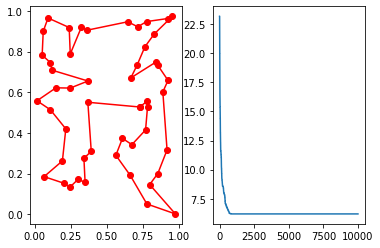

In [51]:
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[1].plot(ga_tsp.generation_best_Y)
plt.show()

## 粒子群算法

In [67]:
from __future__ import division
from random import random, uniform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def objective(x):
    """function we are attempting to optimize
    目标函数、损失函数、适应函数(fitness)
    sphere函数
    """
    return np.sum(np.square(x))


class particle:
    def __init__(self, x_init, dims, w=0.5, c1=1, c2=2):
        """
        :param x_init:
        :param dims:
        :param w: constant inertia weight (how much to weigh the previous velocity)
        :param c1: cognative constant
        :param c2: social constant
        """
        self.position_i = []  # particle position
        self.velocity_i = []  # particle velocity
        self.pos_best_i = []  # best position individual
        self.err_best_i = -1  # best error individual
        self.err_i = -1  # error individual,粒子当前的误差
        self.dims = dims  # velocity dims
        self.w = w
        self.c1 = c1
        self.c2 = c2

        for i in range(0, dims):
            self.velocity_i.append(uniform(-1, 1))  # 初始化速度
            self.position_i.append(uniform(-x_init[0], x_init[0]))  # 初始化位置

    def evaluate(self, cost_func):
        """evaluate current fitness"""
        self.err_i = cost_func(self.position_i)
        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i == -1:
            self.pos_best_i = self.position_i.copy()
            self.err_best_i = self.err_i

    def update_velocity(self, pos_best_g):
        """update new particle velocity"""

        for i in range(self.dims):
            r1, r2 = random(), random()
            vel_cognitive = self.c1 * r1 * (self.pos_best_i[i] - self.position_i[i])
            vel_social = self.c2 * r2 * (pos_best_g[i] - self.position_i[i])
            self.velocity_i[i] = self.w * self.velocity_i[i] + vel_cognitive + vel_social

    def update_position(self, bounds):
        """update the particle position based off new velocity updates"""
        for i in range(self.dims):
            self.position_i[i] = self.position_i[i] + self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i] > bounds[i][1]:
                self.position_i[i] = bounds[i][1]

            # adjust the minimum position if necessary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i] = bounds[i][0]


def minimize(costFunc, x_init, bounds, num_particles, maxiter, verbose=False):
    dims = len(x_init)
    err_best_g = -1  # best error for group
    pos_best_g = []  # best position for group

    # establish the swarm
    swarm = []
    X,V = [],[]  
    for i in range(num_particles):
        swarm.append(particle(x_init, dims))
        X.append(swarm[j].position_i)
        V.append(swarm[j].velocity_i)
 
    X, V= np.array(X).T, np.array(V).T
    plot_contour(bounds, X, V)

    # begin optimization loop
    iter = 0
    fitness_iter = []  # 记录不同迭代次数的种群最优适应度
    while iter < maxiter:
        if verbose:
            print(f'iter:{iter:>4d},best solution:{err_best_g:10.6f}')

        # cycle through particles in swarm and evaluate fitness
        for j in range(num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g = list(swarm[j].position_i)
                err_best_g = float(swarm[j].err_i)
        # cycle through swarm and update velocities and position
        for j in range(0, num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        iter += 1
        fitness_iter.append(err_best_g)

    # print final results
    if verbose:
        print('\nFINAL SOLUTION:')
        print(f'   > {pos_best_g}')
        print(f'   > {err_best_g}\n')

    return err_best_g, pos_best_g, fitness_iter


def plot_contour(bounds, X, V):    
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    # Compute and plot the function in 3D within [-10,10]x[-10,10]
    # 生成坐标和损失值
    x, y = np.array(np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000)))
    z = np.array([objective([i, j]) for i, j in zip(x.flatten(), y.flatten())]).reshape(x.shape)

    # Find the global minimum
    x_min = x.ravel()[z.argmin()]
    y_min = x.ravel()[z.argmin()]

    # Initialize data
    # 初始点得拿出来
    pbest = X
    pbest_obj = np.array([objective(p) for p in X.T])
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()

    # Set up base figure: The contour map
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.set_tight_layout(True)
    img = ax.imshow(z, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', alpha=0.5)
    fig.colorbar(img, ax=ax)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")  # 实际上的最小值
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)  # 粒子的最优位置
    p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)  # 粒子
    p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
    gbest_plot = plt.scatter(gbest[0], gbest[1], marker='*', s=100, color='red', alpha=0.4)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    plt.show()

num_particles = 15
bounds = [(-10, 10), (-10, 10)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
maxiter = 30
x_init = [5, 5]  # initial starting location [x1,x2...]



In [106]:
def demo_func(x):
    x1, x2, x3 = x
    return x1 ** 2 + (x2 - 0.05) ** 2 + x3 ** 2

In [111]:
from sko.PSO import PSO

pso = PSO(func=demo_func, dim=3, pop=40, max_iter=100, lb=[0, -1, 0.5], ub=[1, 1, 1], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

best_x is  [0.         0.05000011 0.5       ] best_y is [0.25]


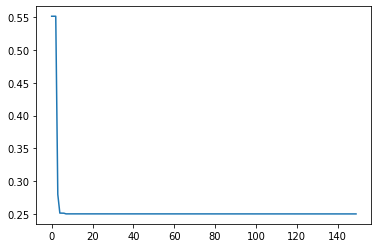

In [21]:
import matplotlib.pyplot as plt

plt.plot(pso.gbest_y_hist)
plt.show()

## 模拟退火算法

理论：[here](https://mp.weixin.qq.com/s?__biz=MzI4ODgwMjYyNQ==&mid=2247488136&idx=1&sn=a90be492aee5bc81ce80c9a6e3adc575&chksm=ec3980a6db4e09b04f4ee023e2902af70878919c0ed563ce9b415be80d02c489b7722061a65b&scene=178&cur_album_id=2151757310631739396#rd)

Intuition：[here](https://www.bilibili.com/video/BV1j64y1Y7FB?spm_id_from=333.337.search-card.all.click&vd_source=78821760a099022a284c04eeb639e1ae)

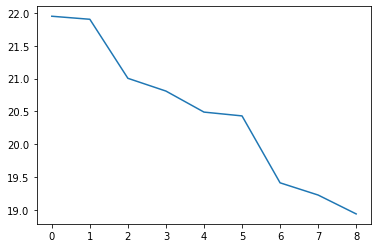

In [68]:
# Demo 展示
import numpy as np
import matplotlib.pyplot as plt


def objective(x):
    """目标函数"""
    return x[0] ** 2.0


class SA:
    def __init__(self, X, bounds, n_iter, sigma, T):
        self.X = X
        self.bounds = bounds
        self.best = X[0]  # 初始化
        self.best_obj = objective([self.best])
        self.n_iter = n_iter
        self.sigma = sigma
        self.T = T
        self.cur, self.cur_obj = self.best, self.best_obj
        self.dims = len(bounds)

    def run(self):
        self.cost = []
        for i in range(self.n_iter):

            # 假设候选解来自正态分布 N(self.cur,sigma)
            candidate = self.cur + np.random.randn(self.dims) * self.sigma
            candidate_obj = objective(candidate)

            # 最优参数和目标值
            if candidate_obj < self.best_obj:
                self.best, self.best_obj = candidate, candidate_obj
                self.cost.append(self.best_obj)

            # 是否接受更差的解
            diff = candidate_obj - self.best_obj
            T = self.T / float(i + 1)  # 当前迭代次数的温度
            metropolis = np.exp(-diff / T)
            if diff < 0 and np.random.rand() < metropolis:
                self.cur, self.cur_obj = candidate, candidate_obj


if __name__ == '__main__':
    bounds = [-5, 5]
    X = np.arange(bounds[0], bounds[1], 0.1)
    T = 10
    n_iter = 1000

    # -----------------------------------------------------
    sa = SA(X, bounds, n_iter, sigma=0.2, T=T)
    sa.run()
    plt.figure()
    plt.plot(sa.cost)  # cost变化情况

In [22]:
demo_func = lambda x: x[0] ** 2 + (x[1] - 0.05) ** 2 + x[2] ** 2

In [23]:
from sko.SA import SA

sa = SA(func=demo_func, x0=[1, 1, 1], T_max=1, T_min=1e-9, L=300, max_stay_counter=150)
best_x, best_y = sa.run()
print('best_x:', best_x, 'best_y', best_y)

best_x: [-1.21024110e-06  4.99871688e-02 -8.85312861e-06] best_y 2.444810054106178e-10


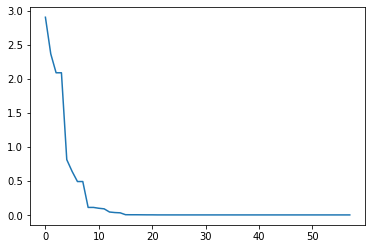

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(pd.DataFrame(sa.best_y_history).cummin(axis=0))
plt.show()

In [97]:
from sko.SA import SA_TSP

sa_tsp = SA_TSP(func=cal_total_distance, x0=range(num_points), T_max=100, T_min=1e-5, L=20 * num_points)

best_points, best_distance = sa_tsp.run()
print(best_points, best_distance, cal_total_distance(best_points))

[ 9 21 38  7 45 32 31  1 34 39 40  3 14 10  5 29 42 49 17 20 44 16 48 12
 35 22  4 11  6 30 26 28 24  2 15 23 37  0 43 18 36 46 13 33 47 25 41 19
  8 27] 19.231684412378716 19.231684412378716


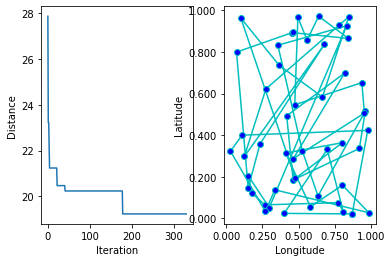

In [98]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 2)

best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(sa_tsp.best_y_history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Distance")
ax[1].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1],
           marker='o', markerfacecolor='b', color='c', linestyle='-')
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
plt.show()

## 蚁群算法

In [31]:
def func(x):
    x1, x2 = x
    return 1 / x1 ** 2 + x1 ** 2 + 1 / x2 ** 2 + x2 ** 2


from sko.AFSA import AFSA

afsa = AFSA(func, n_dim=2, size_pop=50, max_iter=300,
            max_try_num=100, step=0.5, visual=0.3,
            q=0.98, delta=0.5)
best_x, best_y = afsa.run()
print(best_x, best_y)

[1.00000245 0.99998915] 4.00000000049466


[ 0 40  4 11 48 12 28 35 15 39 23 22 49 44 10 20 27  5 36 38 33 45  7  9
 47 14 13 21 34 32 41 31 30  1 24 19  8 26 25 29 18 17 46  3 42 16 37  2
  6 43]
[ 0 40  4 11 48 12 28 35 15 39 23 22 49 44 10 20 27  5 36 38 33 45  7  9
 47 14 13 21 34 32 41 31 30  1 24 19  8 26 25 29 18 17 46  3 42 16 37  2
  6 43  0]


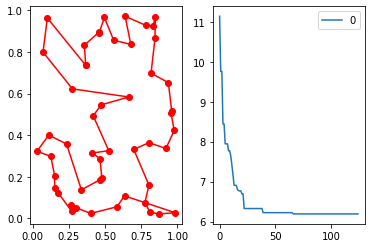

In [96]:
import numpy as np
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt

num_points = 50

points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')


def cal_total_distance(routine):
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


# %% Do ACA
from sko.ACA import ACA_TSP

aca = ACA_TSP(func=cal_total_distance, n_dim=num_points,
              size_pop=50, max_iter=125,
              distance_matrix=distance_matrix)

best_x, best_y = aca.run()

# %% Plot
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_x, [best_x[0]]])
print(best_x)  # 结果序列
print(best_points_)  # 添加起点形成环
best_points_coordinate = points_coordinate[best_points_, :]  # 找到点序列对应的坐标序列
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')  # 连接
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])
plt.show()